## Replicating Figures 2b and 3c
Research Article - Multiplex cerebrospinal fluid proteomics identifies biomarkers for diagnosis and prediction of Alzheimer’s disease ([link](https://doi.org/10.1038/s41562-024-01924-6))

In [26]:
# Importing the necessary libraries
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from adjustText import adjust_text
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

### Figure 2b - Volcano plot

In [27]:
# Importing adnimerge data
adnimerge = pd.read_csv('adnimerge_dataR.csv',low_memory=False)

## Filtering the data using 2 conditions.
# {a} Baseline protein expression data
adnimerge = adnimerge[adnimerge['VISCODE'].str.contains('bl', case=False, na=False)]
# {b} Only control and AD data, removing other conditions
adnimerge = adnimerge[adnimerge['DX.bl'].str.contains('CN|AD', case=False, na=False)]

adnimerge.head()

,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX.bl,AGE,PTGENDER,...,TAU.bl,PTAU.bl,FDG.bl,PIB.bl,AV45.bl,FBB.bl,Years.bl,Month.bl,Month,M
0,2,ADNI1,ADNI1,011_S_0002,11,bl,2005-09-08,CN,74.3,Male,...,NaN,NaN,1.336154,NaN,NaN,NaN,0.0,0.0,0,0
16,3,ADNI1,ADNI1,011_S_0003,11,bl,2005-09-12,AD,81.3,Male,...,239.7,22.83,1.108605,NaN,NaN,NaN,0.0,0.0,0,0
27,5,ADNI1,ADNI1,011_S_0005,11,bl,2005-09-07,CN,73.7,Male,...,337,33.43,1.259559,NaN,NaN,NaN,0.0,0.0,0,0
41,7,ADNI1,ADNI1,022_S_0007,22,bl,2005-10-06,AD,75.4,Male,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0
46,8,ADNI1,ADNI1,011_S_0008,11,bl,2005-09-19,CN,84.5,Female,...,440.2,37.51,1.209653,NaN,NaN,NaN,0.0,0.0,0,0


In [28]:
# Import and preprocess analyte expression data
ana_exp = pd.read_csv('ADNI_Analyte_expression_data.csv')

# Only considering baseline data
ana_exp = ana_exp[ana_exp['VISCODE2'].str.contains('bl', na=False)]

# Merge expression data with baseline ADNI data
ana_exp = pd.merge(ana_exp,adnimerge[['RID','DX.bl','AGE','PTGENDER','PTEDUCAT','APOE4']])

# Binarization of gender for model
ana_exp['PTGENDER'] = ana_exp['PTGENDER'].map({'Male': 1, 'Female': 0})
ana_exp['DX.bl'] = ana_exp['DX.bl'].map({'AD': 1, 'CN': 0})
ana_exp.head()

,RID,EXAMDATE,GUSPECID,Somalogic_Barcode_A,VISCODE2,ExtIdentifier,PlateId,X10000.28,X10001.7,X10003.15,...,X9993.11,X9994.217,X9995.6,X9997.12,X9999.1,DX.bl,AGE,PTGENDER,PTEDUCAT,APOE4
0,4488,2/23/2012,EA808GPZ-05,383704460,bl,EXID40000005905024,P0029626,147.8,171.7,150.1,...,185.1,330.9,484.5,243.6,197.7,0,72.6,1,18,0.0
1,4516,2/28/2012,AA808GRC-05,383704461,bl,EXID40000005944506,P0029652,NaN,181.6,139.8,...,216.0,328.7,509.9,241.0,208.0,0,71.4,1,20,0.0
2,4464,2/17/2012,JA808GXS-04,383704465,bl,EXID40000005959175,P0029653,148.6,178.0,NaN,...,176.2,312.1,NaN,NaN,189.2,0,70.4,1,16,1.0
3,4376,2/2/2012,DA808HBF-05,383704468,bl,EXID40000005912621,P0029649,147.8,197.7,150.3,...,181.2,347.5,607.3,360.1,206.6,0,76.5,0,16,0.0
4,4900,8/29/2012,FA809RBR-04,383704471,bl,EXID40000005916347,P0029651,148.8,191.7,154.4,...,182.1,329.7,483.0,209.8,149.8,0,59.8,0,18,0.0


In [29]:
## Transforming, normalizing and standardizing the data
protein_cols = [col for col in ana_exp.columns if col.startswith('X')]

# Apply natural log transformation
ana_exp[protein_cols] = ana_exp[protein_cols].apply(np.log)

# Z-transform protein expression columns
ana_exp[protein_cols] = ana_exp[protein_cols].apply(lambda x: (x - x.mean()) / x.std())

In [30]:
ana_exp.head()

,RID,EXAMDATE,GUSPECID,Somalogic_Barcode_A,VISCODE2,ExtIdentifier,PlateId,X10000.28,X10001.7,X10003.15,...,X9993.11,X9994.217,X9995.6,X9997.12,X9999.1,DX.bl,AGE,PTGENDER,PTEDUCAT,APOE4
0,4488,2/23/2012,EA808GPZ-05,383704460,bl,EXID40000005905024,P0029626,-0.039662,-0.730809,-0.834574,...,0.120695,-0.261114,-0.157600,-0.608662,0.561513,0,72.6,1,18,0.0
1,4516,2/28/2012,AA808GRC-05,383704461,bl,EXID40000005944506,P0029652,NaN,-0.150355,-2.434326,...,2.225232,-0.479567,0.346307,-0.674175,0.901203,0,71.4,1,20,0.0
2,4464,2/17/2012,JA808GXS-04,383704465,bl,EXID40000005959175,P0029653,0.103478,-0.357684,NaN,...,-0.551042,-2.176622,NaN,NaN,0.267580,0,70.4,1,16,1.0
3,4376,2/2/2012,DA808HBF-05,383704468,bl,EXID40000005912621,P0029649,-0.039662,0.729207,-0.804609,...,-0.169596,1.341843,2.070219,1.777608,0.856032,0,76.5,0,16,0.0
4,4900,8/29/2012,FA809RBR-04,383704471,bl,EXID40000005916347,P0029651,0.139142,0.410088,-0.198964,...,-0.102055,-0.380089,-0.188179,-1.520623,-1.294205,0,59.8,0,18,0.0


In [31]:
# Preprocess data for regression 
# Protein data
ana_exp[protein_cols] = ana_exp[protein_cols].fillna(ana_exp[protein_cols].mean())
protein_columns = ana_exp[protein_cols]
# covariates
covariates = ['AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4']

In [32]:
## Multiple Linear Regression
# Perform Linear regression for each protein
results = []

for protein in protein_columns:
    X = sm.add_constant(ana_exp[['AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4', 'DX.bl']])
    y = ana_exp[protein]
    model = sm.OLS(y, X).fit()
    
    beta = model.params['DX.bl']
    pvalue = model.pvalues['DX.bl']
    
    results.append({
        'protein': protein,
        'beta': beta,
        'pvalue': pvalue,
        '-log10pvalue': -np.log10(pvalue)
    })

results_df = pd.DataFrame(results)

_, adjusted_pvalues, _, _ = multipletests(results_df['pvalue'], method='bonferroni')
results_df['adjusted_pvalue'] = adjusted_pvalues
results_df['-log10adjusted_pvalue'] = -np.log10(adjusted_pvalues)

In [33]:
# Cross Referencing between analytes names and proteins names
ana_prot = pd.read_csv('ADNI_Analyte_protein_info.csv')[['Analytes','EntrezGeneSymbol']]
ana_prot.head()

,Analytes,EntrezGeneSymbol
0,X10000.28,CRYBB2
1,X10001.7,RAF1
2,X10003.15,ZNF41
3,X10006.25,ELK1
4,X10008.43,GUCA1A


In [34]:
# creating a Dataframe for plotting
results = results_df.rename(columns={'protein': 'Analytes'})
fig2 = pd.merge(results,ana_prot,how = 'left', on = 'Analytes')
print(fig2)

       Analytes      beta    pvalue  -log10pvalue  adjusted_pvalue  \
0     X10000.28 -0.013155  0.917896      0.037207              1.0   
1      X10001.7  0.051804  0.690764      0.160670              1.0   
2     X10003.15  0.124119  0.341295      0.466870              1.0   
3     X10006.25  0.007409  0.955390      0.019819              1.0   
4     X10008.43 -0.062758  0.636234      0.196383              1.0   
...         ...       ...       ...           ...              ...   
7003   X9993.11  0.054980  0.664449      0.177538              1.0   
7004  X9994.217 -0.218448  0.091564      1.038276              1.0   
7005    X9995.6  0.172320  0.186112      0.730227              1.0   
7006   X9997.12  0.265143  0.033922      1.469518              1.0   
7007    X9999.1 -0.144526  0.149652      0.824918              1.0   

      -log10adjusted_pvalue EntrezGeneSymbol  
0                      -0.0           CRYBB2  
1                      -0.0             RAF1  
2                 

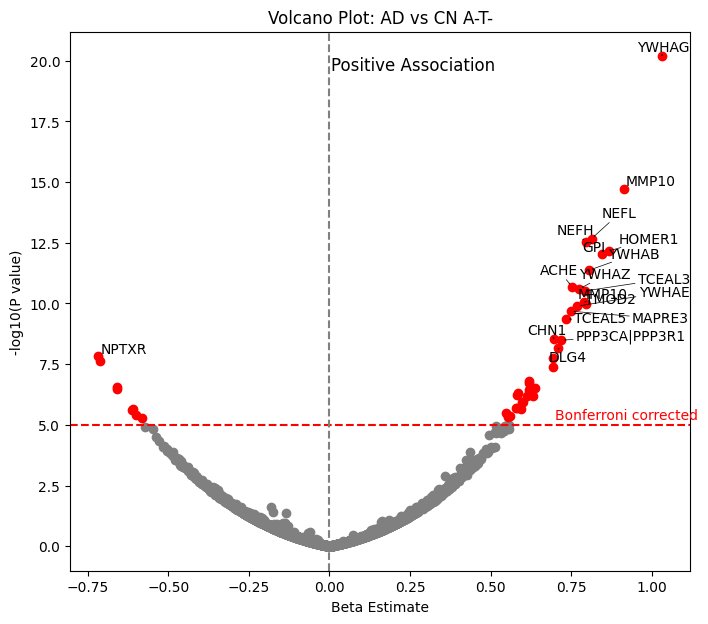

In [35]:
# Create the volcano plot
plt.figure(figsize=(8,7))

# Separate points above and below the threshold
threshold = 5
above_threshold = fig2[fig2['-log10pvalue'] >= threshold]
below_threshold = fig2[fig2['-log10pvalue'] < threshold]

# Plot points below threshold in grey
plt.scatter(below_threshold['beta'], below_threshold['-log10pvalue'], color='grey', alpha=1)

# Plot points above threshold in red
plt.scatter(above_threshold['beta'], above_threshold['-log10pvalue'], color='red', alpha=1)

plt.xlabel('Beta Estimate')
plt.ylabel('-log10(P value)')
plt.title('Volcano Plot: AD vs CN A-T-')

# Add a horizontal line for Bonferroni correction
plt.axhline(5, color='red', linestyle='--')
plt.text(0.7, 5.1, 'Bonferroni corrected', color='red', ha='left', va='bottom')

# Add a vertical line at x=0
plt.axvline(0, color='grey', linestyle='--')

# Label the right quadrant
plt.text(max(fig2['beta'])*0.5, max(fig2['-log10pvalue'])*1, 'Positive Association', ha='right', va='top', fontsize=12)

# Label interesting proteins using adjustText
texts = []
for _, row in fig2.nlargest(19, '-log10pvalue').iterrows():
    texts.append(plt.text(row['beta'], row['-log10pvalue'], row['EntrezGeneSymbol']))

# Adjust text positions to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

plt.show()

### Figure 3c (first ROC Curve)

In [38]:
# Importing the data for Figure 3c
fig3c = pd.read_csv('fig_3c.csv')
fig3c = fig3c[~fig3c['DX_AT_status1'].str.contains('other', case=False, na=False)]
fig3c.head()

,DX_AT_status,DX_AT_status1,Demographic,ProPanel_CNvsAD,ProPanel_CNvsDementia_Demographic,Comb_AB42_PT181_TTAU,YWHAG,YWHAG_Demographic,SMOC1,SMOC1_Demographic
1,Dementia A+T+,A+T+,0.615840,0.987694,0.973473,0.998380,0.700242,0.993094,0.096783,0.540692
2,CN A-T-,CN A-T-,0.552165,0.020784,0.003482,0.005098,-0.853361,0.042227,-0.404357,0.568051
4,CN A-T-,CN A-T-,0.098199,0.006608,0.003631,0.005098,-1.588195,0.009428,-1.432247,0.006910
5,Dementia A+T+,A+T+,0.976402,0.958499,0.985720,0.998380,0.295171,0.989017,-0.058076,0.749286
6,MCI A+T+,A+T+,0.233562,0.962503,0.695921,0.998380,1.077293,0.971520,0.296463,0.609249


/var/folders/mh/p8rsw7z90bv6kv8r8qnf4tnr0000gn/T/ipykernel_1377/1668942559.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fig3c['DX_AT_status1'] = fig3c['DX_AT_status1'].replace({'CN A-T-': 0, 'A+T+': 1}).astype(int)


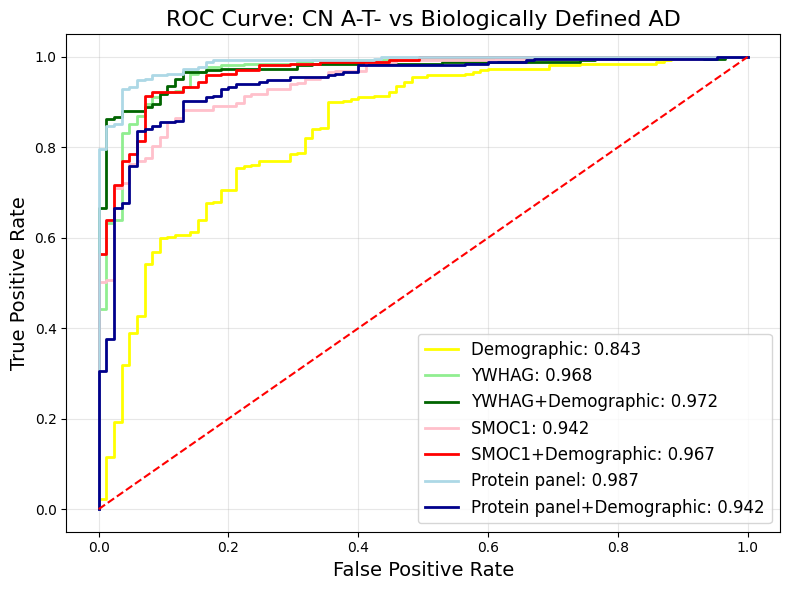

In [39]:
# Convert target labels ('CN A-T-' and 'A+T+') to binary format (0 and 1)
fig3c['DX_AT_status1'] = fig3c['DX_AT_status1'].replace({'CN A-T-': 0, 'A+T+': 1}).astype(int)

# Define the labels
y_true = fig3c['DX_AT_status1']

# Define features, colors, and labels for the legend
features = ['Demographic', 'YWHAG', 'YWHAG_Demographic', 'SMOC1', 'SMOC1_Demographic', 'ProPanel_CNvsAD', 'ProPanel_CNvsDementia_Demographic']
colors = ['yellow', 'lightgreen', 'darkgreen', 'pink', 'red', 'lightblue', 'darkblue']
labels = ['Demographic', 'YWHAG', 'YWHAG+Demographic', 'SMOC1', 'SMOC1+Demographic', 'Protein panel', 'Protein panel+Demographic']

## Plot ROC curves for each feature
plt.figure(figsize=(8, 6))
for feature, color, label in zip(features, colors, labels):
    # Indexing and referencing non-NA values
    y_scores = fig3c[feature].dropna()
    valid_indices = y_scores.index
    valid_y_true = y_true.loc[valid_indices]
    
    # fpr and tpr derivation using roc_curve function
    fpr, tpr, _ = roc_curve(valid_y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{label}: {roc_auc:.3f}')

# Plot beautification
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve: CN A-T- vs Biologically Defined AD', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()